In [39]:
import seaborn as sns
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import itertools
from sklearn.metrics import confusion_matrix

In [31]:
# GLOBAL VARS
TRAIN_DIR = 'asl-alphabet/asl_alphabet_train'
TEST_DIR = 'asl-alphabet/asl-alphabet-test'

TARGET_SIZE = (64, 64)
TARGET_DIMS = (64, 64, 3) # add channel for RGB
N_CLASSES = 29
VALIDATION_SPLIT = 0.15
BATCH_SIZE = 64

# Model saving for easier local iterations
MODEL_DIR = 'aslalphabetcnnmodel1'
MODEL_PATH = MODEL_DIR + '/cnn-model_try_2.h5'
MODEL_WEIGHTS_PATH = MODEL_DIR + '/cnn-model.weights.h5'
SAVE = True

In [24]:
def make_generator(group):
    
    # used in preprocessing the image
    augmentor_options = {
        'samplewise_center': True,
        'samplewise_std_normalization': True,
        'preprocessing_function':lambda x: cv2.Sobel(x, cv2.CV_64F, 0, 1, ksize=5),
        #'validation_split': VALIDATION_SPLIT
    }
    
    # used in reading from directory
    flow_options = {
        'target_size': TARGET_SIZE,
        'batch_size': BATCH_SIZE,
        'shuffle': True,
        #'subset': group
    }

    generator = ImageDataGenerator(**augmentor_options)
    return generator.flow_from_directory(TEST_DIR, **flow_options)

In [19]:
def build_model(save=False):
    
    model = Sequential()
    model.add(Conv2D(64, kernel_size=4, strides=1, activation='relu', input_shape=TARGET_DIMS))
#     model.add(Conv2D(64, kernel_size=4, strides=2, activation='relu'))
    model.add(Dropout(0.4))
#     model.add(MaxPooling2D())
#     model.add(Conv2D(128, kernel_size=4, strides=1, activation='relu'))
#     model.add(Conv2D(128, kernel_size=4, strides=2, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Conv2D(256, kernel_size=4, strides=1, activation='relu'))
#     model.add(Conv2D(256, kernel_size=4, strides=2, activation='relu'))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(N_CLASSES, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.save(MODEL_PATH) 
    return model

CNN_MODEL = build_model(save=SAVE)
CNN_MODEL.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 61, 61, 64)        3136      
_________________________________________________________________
dropout (Dropout)            (None, 61, 61, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 238144)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 238144)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               60965120  
_________________________________________________________________
dense_1 (Dense)              (None, 29)                7453      
Total params: 60,975,709
Trainable params: 60,975,709
Non-trainable params: 0
________________________________________________________________

In [22]:
def fit_model(model, train_generator, val_generator, save):
    fitted = model.fit_generator(train_generator, epochs=2, validation_data=val_generator)
    if save: model.save_weights(MODEL_WEIGHTS_PATH)
    return fitted, model


CNN_TRAIN_GENERATOR = make_generator('training')
CNN_VAL_GENERATOR = make_generator('validation')

start_time = time.time()
fitted, model = fit_model(CNN_MODEL, CNN_TRAIN_GENERATOR, CNN_VAL_GENERATOR, save=False)
print('Fitting the model took ~{:.0f} second(s).'.format(time.time() - start_time))

Found 56270 images belonging to 29 classes.
Found 9901 images belonging to 29 classes.
Epoch 1/2
880/880 [==============================] - 1551s 2s/step - loss: 0.0770 - acc: 0.9779 - val_loss: 1.9015 - val_acc: 0.6976
Epoch 2/2
880/880 [==============================] - 1789s 2s/step - loss: 0.0625 - acc: 0.9821 - val_loss: 2.3790 - val_acc: 0.6483
Fitting the model took ~3340 second(s).


In [27]:
CNN_MODEL = model

In [28]:
def evaluate_model(generator):
    start_time = time.time()
    evaluations = CNN_MODEL.evaluate_generator(generator)
    for i in range(len(CNN_MODEL.metrics_names)):
        print("{}: {:.2f}%".format(
            CNN_MODEL.metrics_names[i], evaluations[i] * 100))
    print('Took {:.0f} seconds to evaluate this set.'.format(
        time.time() - start_time))

    start_time = time.time()
    predictions = CNN_MODEL.predict_generator(generator)
    print('Took {:.0f} seconds to get predictions on this set.'.format(
        time.time() - start_time))

    y_pred = np.argmax(predictions, axis=1)
    y_true = generator.classes
    return dict(y_pred=y_pred, y_true=y_true)

def evaluate_test_dataset():
    test_gen = make_generator('test')
    return evaluate_model(test_gen)

In [32]:
CNN_TEST_SET_EVAL = evaluate_test_dataset()

Found 870 images belonging to 29 classes.
loss: 1274.82%
acc: 5.63%
Took 4 seconds to evaluate this set.
Took 4 seconds to get predictions on this set.


Confusion matrix, without normalization


<Figure size 1152x1152 with 0 Axes>

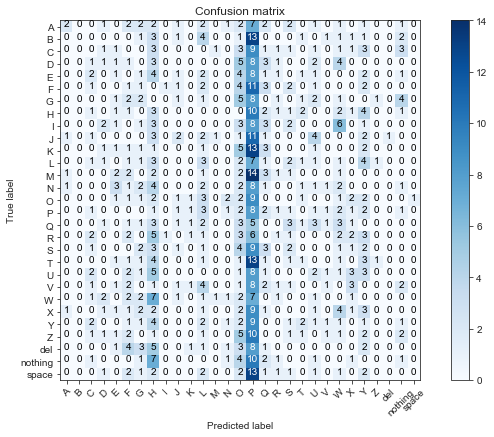

In [45]:
CLASSES = ['A','B', 'C','D', 'E','F', 'G', 
           'H', 'I','J', 'K','L', 'M','N', 
           'O','P', 'Q','R', 'S','T', 'U', 
           'V','W','X','Y','Z','del','nothing','space']
           
           
def plot_confusion_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues):
    '''
    Plot a confusion matrix heatmap using matplotlib. This code was obtained from
    the scikit-learn documentation:

    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return           

def plot_confusion_matrix_with_default_options(y_pred, y_true, classes):
    cm = confusion_matrix(y_true, y_pred)
    with sns.axes_style('ticks'):
        plt.figure(figsize=(9, 6))
        plot_confusion_matrix(cm, classes)
        plt.show()
    return
    
with sns.axes_style('ticks'):
    plot_confusion_matrix_with_default_options(**CNN_TEST_SET_EVAL, classes=CLASSES)

In [47]:
confusion_matrix(CNN_TEST_SET_EVAL['y_true'], CNN_TEST_SET_EVAL['y_true'])

array([[30,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 30,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 30,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 30,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 30,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 30,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 30,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 30,  0,  0,  0,  0,  0,  0,  0,  